# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

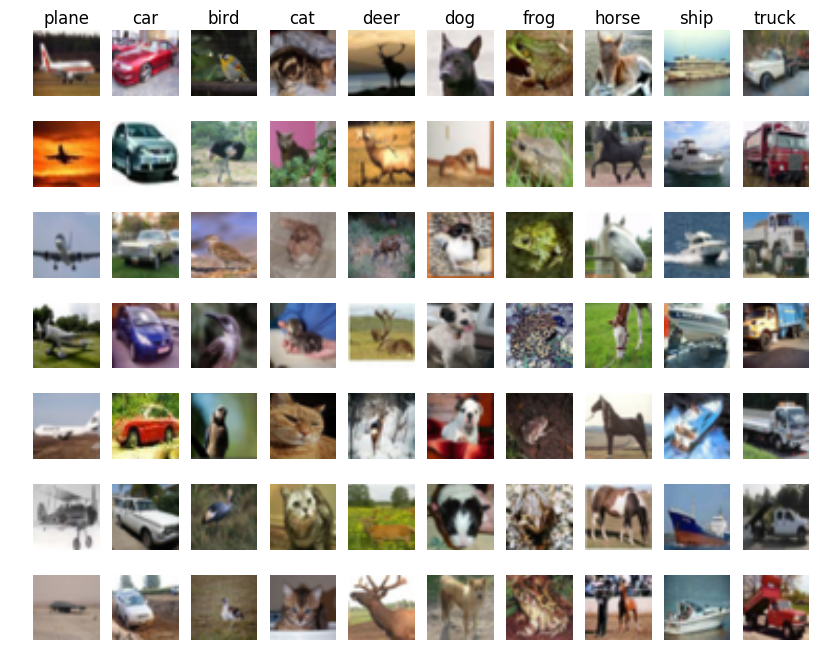

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
import lasagne
import theano
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [16]:
input_layer = lasagne.layers.InputLayer(shape=(None,3, 32, 32), input_var=input_X)
print input_layer.shape

mid_1_layer = lasagne.layers.Conv2DLayer(input_layer, num_filters = 8, filter_size=3, nonlinearity=rectify, pad=1,  name = "mid_1")
mid_2_layer = lasagne.layers.MaxPool2DLayer(mid_1_layer, pool_size=(2,2))
print mid_1_layer.output_shape
print mid_2_layer.output_shape

mid_3_layer = lasagne.layers.Conv2DLayer(mid_2_layer, num_filters = 16, filter_size=3, nonlinearity=rectify, pad=1,  name = "mid_2")
mid_4_layer = lasagne.layers.MaxPool2DLayer(mid_3_layer, pool_size=(2,2))
print mid_3_layer.output_shape
print mid_4_layer.output_shape

mid_5_layer = lasagne.layers.Conv2DLayer(mid_4_layer, num_filters = 64, filter_size=3, nonlinearity=rectify, pad=1, name = "mid_3")
mid_6_layer = lasagne.layers.MaxPool2DLayer(mid_5_layer, pool_size=(2,2))
print mid_5_layer.output_shape
print mid_6_layer.output_shape
#
#mid_7_layer = lasagne.layers.Conv2DLayer(mid_6_layer, num_filters = 256, filter_size=3, nonlinearity=rectify, name = "mid_4")
#mid_8_layer = lasagne.layers.MaxPool2DLayer(mid_7_layer, pool_size=(2,2))
#print mid_7_layer.output_shape
#print mid_8_layer.output_shape
#
mid_9_layer = lasagne.layers.DenseLayer(mid_6_layer, num_units=400, nonlinearity=rectify, name = "mid_5")
mid_10_layer = lasagne.layers.DropoutLayer(mid_9_layer, p=0.5)
print mid_9_layer.output_shape
print mid_10_layer.output_shape

# Для вдохновления 
# - http://torch.ch/blog/2015/07/30/cifar.html
# - http://www.robots.ox.ac.uk/~vgg/research/very_deep/
# - https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
dense_output = lasagne.layers.DenseLayer(mid_10_layer, num_units = 10, nonlinearity=softmax)
print dense_output.output_shape

(None, 3, 32, 32)
(None, 8, 32, 32)
(None, 8, 16, 16)
(None, 16, 16, 16)
(None, 16, 8, 8)
(None, 64, 8, 8)
(None, 64, 4, 4)
(None, 400)
(None, 400)
(None, 10)


In [17]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [18]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[mid_1.W, mid_1.b, mid_2.W, mid_2.b, mid_3.W, mid_3.b, mid_5.W, mid_5.b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [19]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

updates_sgd = lasagne.updates.adam(loss, all_weights,learning_rate=0.01)

In [25]:
THEANO_FLAGS='optimizer_excluding=conv_dnn, optimizer_excluding=conv_gemm'
print theano.config

floatX (('float64', 'float32', 'float16')) 
    Doc:  Default floating-point precision for python casts.

Note: float16 support is experimental, use at your own risk.
    Value:  float64

warn_float64 (('ignore', 'warn', 'raise', 'pdb')) 
    Doc:  Do an action when a tensor variable with float64 dtype is created. They can't be run on the GPU with the current(old) gpu back-end and are slow with gamer GPUs.
    Value:  ignore

cast_policy (('custom', 'numpy+floatX')) 
    Doc:  Rules for implicit type casting
    Value:  custom

int_division (('int', 'raise', 'floatX')) 
    Doc:  What to do when one computes x / y, where both x and y are of integer types
    Value:  int

device (cpu, gpu*, opencl*, cuda*) 
    Doc:  Default device for computations. If cuda* or opencl*, change thedefault to try to move computation to the GPU. Do not use upper caseletters, only lower case even if NVIDIA uses capital letters.
    Value:  cpu

init_gpu_device (, gpu*, opencl*, cuda*) 
    Doc:  Initialize 

In [26]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates_sgd, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

ERROR (theano.gof.opt): Optimization failure due to: local_abstractconv_check
ERROR (theano.gof.opt): node: AbstractConv2d{convdim=2, border_mode=(1, 1), subsample=(1, 1), filter_flip=True, imshp=(None, 3, 32, 32), kshp=(8, 3, 3, 3), filter_dilation=(1, 1)}(X, mid_1.W)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/nikita/documents/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "/home/nikita/documents/anaconda2/lib/python2.7/site-packages/theano/tensor/nnet/opt.py", line 603, in local_abstractconv_check
    node.op.__class__.__name__)
AssertionError: AbstractConv2d Theano optimization failed: there is no implementation available supporting the requested options. Did you exclude both "conv_dnn" and "conv_gemm" from the optimizer? If on GPU, is cuDNN available and does the GPU support it? If on CPU, do you have a BLAS library installed Theano c

AssertionError: AbstractConv2d Theano optimization failed: there is no implementation available supporting the requested options. Did you exclude both "conv_dnn" and "conv_gemm" from the optimizer? If on GPU, is cuDNN available and does the GPU support it? If on CPU, do you have a BLAS library installed Theano can link against?

### Вот и всё, пошли её учить

In [12]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [49]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
#
#    # And a full pass over the validation data:
#    val_acc = 0
#    val_batches = 0
#    for batch in iterate_minibatches(X_val, y_val, batch_size):
#        inputs, targets = batch
#        val_acc += accuracy_fun(inputs, targets)
#       val_batches += 1
#
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    #print("  validation accuracy:\t\t{:.2f} %".format(
    #    val_acc / val_batches * 100))

ValueError: The hardcoded shape for the image stack size (3) isn't the run time shape (32).
Apply node that caused the error: ConvOp{('imshp', (3, 32, 32)),('kshp', (2, 2)),('nkern', 8),('bsize', None),('dx', 1),('dy', 1),('out_mode', 'valid'),('unroll_batch', None),('unroll_kern', None),('unroll_patch', True),('imshp_logical', (3, 32, 32)),('kshp_logical', (2, 2)),('kshp_logical_top_aligned', True)}(X, mid_1.W)
Toposort index: 14
Inputs types: [TensorType(float64, 4D), TensorType(float64, 4D)]
Inputs shapes: [(50, 32, 32, 3), (8, 3, 2, 2)]
Inputs strides: [(24576, 256, 8, 8192), (96, 32, 16, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{Add}[(0, 0)](ConvOp{('imshp', (3, 32, 32)),('kshp', (2, 2)),('nkern', 8),('bsize', None),('dx', 1),('dy', 1),('out_mode', 'valid'),('unroll_batch', None),('unroll_kern', None),('unroll_patch', True),('imshp_logical', (3, 32, 32)),('kshp_logical', (2, 2)),('kshp_logical_top_aligned', True)}.0, InplaceDimShuffle{x,0,x,x}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/nikita/documents/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nikita/documents/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nikita/documents/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/nikita/documents/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-251198cc175e>", line 2, in <module>
    y_predicted = lasagne.layers.get_output(dense_output)
  File "/home/nikita/documents/anaconda2/lib/python2.7/site-packages/lasagne/layers/helper.py", line 191, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "/home/nikita/documents/anaconda2/lib/python2.7/site-packages/lasagne/layers/conv.py", line 330, in get_output_for
    conved = self.convolve(input, **kwargs)
  File "/home/nikita/documents/anaconda2/lib/python2.7/site-packages/lasagne/layers/conv.py", line 608, in convolve
    filter_flip=self.flip_filters)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3